In [1]:
# WikiText-103 is a large-scale language modeling dataset extracted from verified Good and Featured articles on Wikipedia
# # > 100M words across 29k articles
from datasets import load_dataset
import pandas as pd
wiki_dataset = load_dataset("yehzw/wikitext-103", "raw")
print(wiki_dataset)
_ = pd.DataFrame.from_dict(wiki_dataset["train"][:5])  
print(_.head())

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 29567
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 60
    })
    test: Dataset({
        features: ['text'],
        num_rows: 62
    })
})
                                                text
0  = Valkyria Chronicles III =\nSenjō no Valkyria...
1  = Tower Building of the Little Rock Arsenal =\...
2  = Cicely Mary Barker =\nCicely Mary Barker (28...
3  = Gambia women's national football team =\nThe...
4  = Plain maskray =\nThe plain maskray or brown ...


In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.trainers import UnigramTrainer
from tokenizers.pre_tokenizers import Sequence, Split, Digits
_pre_tokenizer = Sequence([
    Split(pattern=r"\s+", behavior="isolated"), # split on whitespace, e.g. "it is" -> ["it", "is"], isolated means keep the split tokens
    Digits(individual_digits=False) # split digits from letters, e.g. "word123" -> ["word", "123"]
])
_special_tokens = ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
_vocab_size = 10_000

# Initialize with special tokens vocabulary
# Each token needs a score (log probability), 0.0 is a common default
initial_vocab = [(token, 0.0) for token in _special_tokens]
tokenizer = Tokenizer(Unigram(vocab=initial_vocab, unk_id=0))
trainer = UnigramTrainer(vocab_size=_vocab_size, special_tokens=_special_tokens)
tokenizer.pre_tokenizer = _pre_tokenizer

In [ ]:
tokenizer.train_from_iterator(
	(row["text"] for split in ["train", "validation", "test"] for row in wiki_dataset[split]),
	trainer=trainer
)

In [ ]:
tokenizer.save("./tmp/unigram-tokenizer.json")

In [3]:
tokenizer = Tokenizer.from_file("./tmp/unigram-tokenizer.json")

In [ ]:
sentence = "Hello, devs😁! Welcome to the 1st AI crash course."
encoded = tokenizer.encode(sentence)
print("Tokens:", encoded.tokens)
print("IDs:", encoded.ids)
decoded = tokenizer.decode(encoded.ids, skip_special_tokens=True)
print("Decoded:", decoded)

Tokens: ['H', 'ell', 'o', ',', ' de', 'v', 's', '😁', '!', ' W', 'el', 'com', 'e', ' to the ', '1', 'st', ' A', 'I', ' crash', ' course', '.']
IDs: [316, 330, 46, 6, 122, 440, 5, 0, 1292, 128, 80, 558, 22, 1921, 7, 105, 100, 230, 3737, 2087, 20]
Decoded: H ell o ,  de v s [UNK] !  W el com e  to the  1 st  A I  crash  course .


In [23]:
import math

# Get all tokens from the tokenizer's vocabulary
vocab = tokenizer.get_vocab()
print(f"Vocabulary size: {len(vocab):,}")

# For Unigram, we need to get scores from the saved JSON
# since the Python API doesn't expose them directly
import json

with open("./tmp/unigram-tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_data = json.load(f)

# Extract vocabulary with scores
vocab_with_scores = tokenizer_data["model"]["vocab"]
token_probs = {token: math.exp(score) for token, score in vocab_with_scores}

print("\n=== Top 20 Highest Probability Tokens ===")
top_tokens = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)[:20]
for i, (token, prob) in enumerate(top_tokens, 1):
    # Show the token with special characters visible
    token_repr = repr(token) if len(token) < 15 else repr(token[:12]) + "..."
    print(f"{i:2d}. {token_repr:<20} | Prob: {prob:.6f} | Log Prob: {math.log(prob):.4f}")

print("\n=== Bottom 20 Lowest Probability Tokens ===")
bottom_tokens = sorted(token_probs.items(), key=lambda x: x[1])[:20]
for i, (token, prob) in enumerate(bottom_tokens, 1):
    token_repr = repr(token) if len(token) < 15 else repr(token[:12]) + "..."
    print(f"{i:2d}. {token_repr:<20} | Prob: {prob:.8f} | Log Prob: {math.log(prob):.4f}")

print(f"\n=== Vocabulary Statistics ===")
print(f"Total tokens: {len(token_probs):,}")
print(f"Sum of probabilities: {sum(token_probs.values()):.6f} (should be ~1.0 for normalized probabilities)")
print(f"Mean probability: {sum(token_probs.values()) / len(token_probs):.8f}")
print(f"Median probability: {sorted(token_probs.values())[len(token_probs)//2]:.8f}")

Vocabulary size: 10,000

=== Top 20 Highest Probability Tokens ===
 1. '[UNK]'              | Prob: 1.000000 | Log Prob: 0.0000
 2. '[CLS]'              | Prob: 1.000000 | Log Prob: 0.0000
 3. '[SEP]'              | Prob: 1.000000 | Log Prob: 0.0000
 4. '[PAD]'              | Prob: 1.000000 | Log Prob: 0.0000
 5. '[MASK]'             | Prob: 1.000000 | Log Prob: 0.0000
 6. 's'                  | Prob: 0.024198 | Log Prob: -3.7215
 7. ','                  | Prob: 0.017544 | Log Prob: -4.0431
 8. '1'                  | Prob: 0.013966 | Log Prob: -4.2711
 9. ' '                  | Prob: 0.013756 | Log Prob: -4.2863
10. '0'                  | Prob: 0.012550 | Log Prob: -4.3780
11. ' and'               | Prob: 0.009934 | Log Prob: -4.6118
12. ' the'               | Prob: 0.009673 | Log Prob: -4.6384
13. ' of'                | Prob: 0.008392 | Log Prob: -4.7805
14. '2'                  | Prob: 0.008368 | Log Prob: -4.7833
15. ' in'                | Prob: 0.007583 | Log Prob: -4.8819
16. '9' 

In [20]:
# Demonstrate how Unigram chooses between multiple tokenization options
import matplotlib.pyplot as plt
import numpy as np

def get_token_probability(token, token_probs):
    """Get probability for a token, return very small value if not found"""
    return token_probs.get(token, 1)

def calculate_sequence_probability(tokens, token_probs):
    """Calculate probability of a token sequence (product of individual probabilities)"""
    prob = 1.0
    for token in tokens:
        prob *= get_token_probability(token, token_probs)
    return prob

# Example: Show different ways to tokenize a word
test_words = ["unhappiness", "tokenization", "artificial", "intelligence"]

print("=== How Unigram Selects Best Tokenization ===\n")

for word in test_words:
    print(f"\nWord: '{word}'")
    
    # Get actual tokenization
    encoded = tokenizer.encode(word)
    actual_tokens = encoded.tokens
    actual_prob = calculate_sequence_probability(actual_tokens, token_probs)
    
    print(f"  Chosen tokenization: {actual_tokens}")
    print(f"  Sequence probability: {actual_prob:.2e}")
    print(f"  Log probability: {math.log(actual_prob):.4f}")
    
    # Show individual token probabilities
    print(f"  Individual token probabilities:")
    for token in actual_tokens:
        prob = get_token_probability(token, token_probs)
        print(f"    '{token}': {prob:.6f}")

=== How Unigram Selects Best Tokenization ===


Word: 'unhappiness'
  Chosen tokenization: ['un', 'h', 'app', 'i', 'ness']
  Sequence probability: 5.36e-17
  Log probability: -37.4653
  Individual token probabilities:
    'un': 0.000658
    'h': 0.001525
    'app': 0.000108
    'i': 0.001872
    'ness': 0.000264

Word: 'tokenization'
  Chosen tokenization: ['to', 'ken', 'ization']
  Sequence probability: 3.35e-12
  Log probability: -26.4233
  Individual token probabilities:
    'to': 0.000504
    'ken': 0.000069
    'ization': 0.000096

Word: 'artificial'
  Chosen tokenization: ['art', 'ific', 'ial']
  Sequence probability: 5.77e-12
  Log probability: -25.8784
  Individual token probabilities:
    'art': 0.000205
    'ific': 0.000070
    'ial': 0.000402

Word: 'intelligence'
  Chosen tokenization: ['int', 'ell', 'ig', 'ence']
  Sequence probability: 1.24e-14
  Log probability: -32.0199
  Individual token probabilities:
    'int': 0.000164
    'ell': 0.000425
    'ig': 0.000552
    'enc

In [21]:
# Compare tokenization choices: Why Unigram picks certain splits
sentence = "Hello, devs😁! Welcome to the 1st AI crash course."
encoded = tokenizer.encode(sentence)

print("=== Sentence Tokenization Analysis ===\n")
print(f"Original: {sentence}")
print(f"Tokens: {encoded.tokens}")
print(f"\nToken-by-Token Analysis:")
print(f"{'Token':<20} {'Probability':<15} {'Log Prob':<12} {'Cumulative Log Prob':<20}")
print("=" * 70)

cumulative_log_prob = 0.0
for token in encoded.tokens:
    prob = get_token_probability(token, token_probs)
    log_prob = math.log(prob) if prob > 0 else -float('inf')
    cumulative_log_prob += log_prob
    print(f"{token:<20} {prob:<15.8f} {log_prob:<12.4f} {cumulative_log_prob:<20.4f}")

total_sequence_prob = calculate_sequence_probability(encoded.tokens, token_probs)
print(f"\nTotal sequence probability: {total_sequence_prob:.2e}")
print(f"Total sequence log probability: {math.log(total_sequence_prob):.4f}")
print(f"\n💡 Unigram chooses the tokenization that maximizes this total probability!")

=== Sentence Tokenization Analysis ===

Original: Hello, devs😁! Welcome to the 1st AI crash course.
Tokens: ['H', 'ell', 'o', ',', ' de', 'v', 's', '😁', '!', ' W', 'el', 'com', 'e', ' to the ', '1', 'st', ' A', 'I', ' crash', ' course', '.']

Token-by-Token Analysis:
Token                Probability     Log Prob     Cumulative Log Prob 
H                    0.00044659      -7.7139      -7.7139             
ell                  0.00042532      -7.7627      -15.4765            
o                    0.00270827      -5.9114      -21.3880            
,                    0.01754371      -4.0431      -25.4310            
 de                  0.00099291      -6.9149      -32.3459            
v                    0.00033445      -8.0030      -40.3489            
s                    0.02419804      -3.7215      -44.0704            
😁                    1.00000000      0.0000       -44.0704            
!                    0.00013812      -8.8874      -52.9578            
 W                   0

In [22]:
# Show how Unigram handles rare vs common words differently
common_words = ["the", "is", "and", "of", "to"]
rare_words = ["antidisestablishmentarianism", "pneumonoultramicroscopicsilicovolcanoconiosis"]

print("=== Common Words vs Rare Words ===\n")

print("COMMON WORDS:")
for word in common_words:
    encoded = tokenizer.encode(word)
    tokens = encoded.tokens
    prob = calculate_sequence_probability(tokens, token_probs)
    print(f"  '{word}' → {tokens} | Prob: {prob:.6f} | Tokens: {len(tokens)}")

print("\nRARE WORDS:")
for word in rare_words:
    encoded = tokenizer.encode(word)
    tokens = encoded.tokens
    prob = calculate_sequence_probability(tokens, token_probs)
    print(f"  '{word[:30]}...' → {tokens[:5]}... | Prob: {prob:.2e} | Tokens: {len(tokens)}")

print("\n💡 Common words often become single tokens with high probability")
print("💡 Rare words split into multiple subwords with lower combined probability")

=== Common Words vs Rare Words ===

COMMON WORDS:
  'the' → ['the'] | Prob: 0.000224 | Tokens: 1
  'is' → ['is'] | Prob: 0.001056 | Tokens: 1
  'and' → ['and'] | Prob: 0.000391 | Tokens: 1
  'of' → ['of'] | Prob: 0.000086 | Tokens: 1
  'to' → ['to'] | Prob: 0.000504 | Tokens: 1

RARE WORDS:
  'antidisestablishmentarianism...' → ['ant', 'id', 'is', 'est', 'ab']... | Prob: 2.93e-33 | Tokens: 10
  'pneumonoultramicroscopicsilico...' → ['p', 'ne', 'um', 'on', 'oul']... | Prob: 8.62e-68 | Tokens: 21

💡 Common words often become single tokens with high probability
💡 Rare words split into multiple subwords with lower combined probability


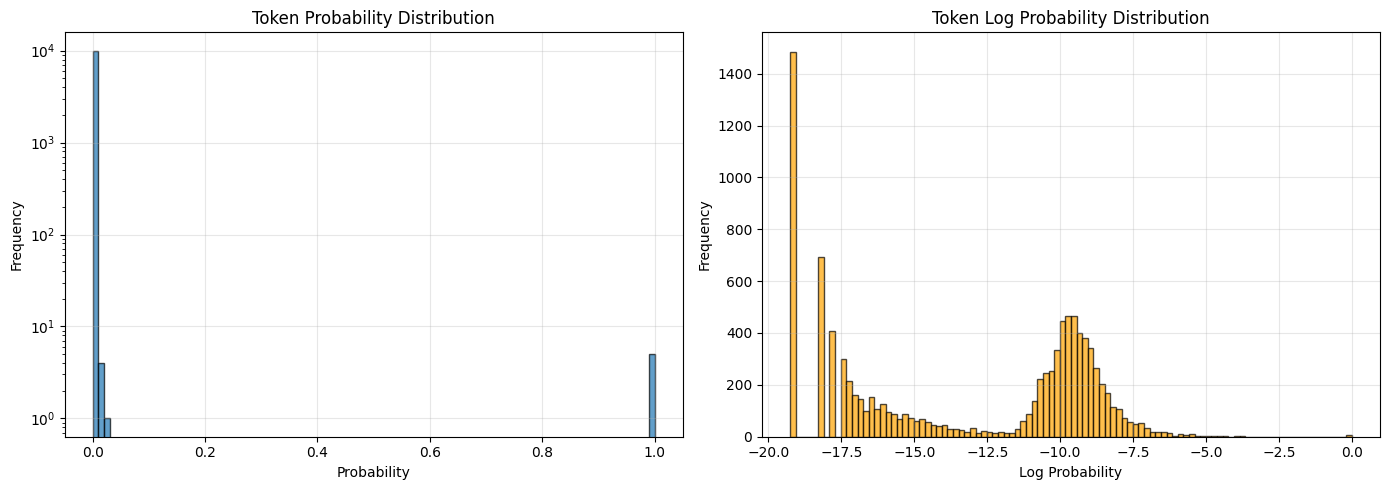


=== Probability Distribution Statistics ===
Min probability: 4.33e-09
Max probability: 1.00e+00
Median probability: 1.52e-05
Mean log probability: -13.2965


In [24]:
# Visualize probability distribution
import matplotlib.pyplot as plt
import numpy as np

# Get probabilities and convert to log scale for better visualization
probs = list(token_probs.values())
log_probs = [math.log(p) if p > 0 else -100 for p in probs]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Probability distribution
axes[0].hist(probs, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Token Probability Distribution')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: Log probability distribution
axes[1].hist(log_probs, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Token Log Probability Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Probability Distribution Statistics ===")
print(f"Min probability: {min(probs):.2e}")
print(f"Max probability: {max(probs):.2e}")
print(f"Median probability: {np.median(probs):.2e}")
print(f"Mean log probability: {np.mean(log_probs):.4f}")

In [27]:

# Show Unigram-specific features using T5 (SentencePiece with Unigram algorithm)
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
print(f"{tokenizer.__class__.__name__} Vocabulary size:", tokenizer.vocab_size)

print("=== Unigram Tokenization Features (T5) ===\n")

# 1. Space marker (▁)
print("1. Space Handling:")
text = "Hello world"
tokens = tokenizer.tokenize(text)
print(f"   '{text}' → {tokens}")
print("   Notice: '▁' marks word boundaries\n")

# 2. Rare word splitting
print("2. Rare Word Handling:")
rare_word = "antidisestablishmentarianism"
tokens = tokenizer.tokenize(rare_word)
print(f"   '{rare_word}' →")
print(f"   {tokens}")
print(f"   Split into {len(tokens)} subword tokens\n")

# 3. Numbers
print("3. Number Tokenization:")
numbers = ["123", "1234", "12345"]
for num in numbers:
    tokens = tokenizer.tokenize(num)
    print(f"   '{num}' → {tokens} ({len(tokens)} tokens)")

print("\n4. Multiple Segmentation Possibilities:")
print("   Unigram considers multiple ways to split text")
print("   and chooses the most probable segmentation")
print("   based on learned token probabilities.")

T5TokenizerFast Vocabulary size: 32100
=== Unigram Tokenization Features (T5) ===

1. Space Handling:
   'Hello world' → ['▁Hello', '▁world']
   Notice: '▁' marks word boundaries

2. Rare Word Handling:
   'antidisestablishmentarianism' →
   ['▁anti', 'd', 'is', 'est', 'abl', 'ish', 'ment', 'aria', 'nism']
   Split into 9 subword tokens

3. Number Tokenization:
   '123' → ['▁', '123'] (2 tokens)
   '1234' → ['▁12', '34'] (2 tokens)
   '12345' → ['▁', '123', '45'] (3 tokens)

4. Multiple Segmentation Possibilities:
   Unigram considers multiple ways to split text
   and chooses the most probable segmentation
   based on learned token probabilities.



#### Unigram Language Model

The Unigram tokenization algorithm, used in models like T5 and mBART, takes a probabilistic approach to tokenization **during training** but remains **fully deterministic during inference**.

**Key Properties:**
1. ✅ **Deterministic**: The same text always produces the same tokens
2. ✅ **Reversible**: Can perfectly reconstruct original text from tokens
3. ✅ **Lossless**: No information is lost in tokenization

**How It Works:**

**Training Phase (Non-deterministic optimization):**
- Starts with large vocabulary
- Learns probability for each token based on corpus statistics
- Iteratively removes low-impact tokens
- Results in optimized vocabulary with learned probabilities

**Inference Phase (Deterministic selection):**
- For any input text, considers all possible segmentations
- Calculates probability of each segmentation using learned token probabilities
- **Always selects the segmentation with highest probability** (Viterbi algorithm)
- No randomness—same input = same output

**Example:**
```python
# Unigram considers multiple ways to tokenize "unhappiness":
# 1. ["un", "happiness"]      P = 0.001234 ← SELECTED (highest)
# 2. ["un", "hap", "pi", "ness"]  P = 0.000891
# 3. ["unhap", "pi", "ness"]   P = 0.000456

# Always chooses option 1 (deterministic)
```

**Advantages over BPE/WordPiece:**
- More theoretically grounded (probability-based)
- Considers global context (all possible segmentations)
- Often produces more linguistically coherent splits

In [32]:
# Demonstrate deterministic behavior of Unigram
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

# Tokenize the same text multiple times
text = "unhappiness"

print("=== Demonstrating Deterministic Behavior ===\n")
print(f"Input text: '{text}'\n")

for i in range(5):
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    print(f"Iteration {i+1}: {tokens} | IDs: {token_ids}")

print("\n✅ Same input always produces the same tokenization!")
print("✅ Unigram is DETERMINISTIC despite using probabilities")

print("\n=== Demonstrating Reversibility ===\n")

# Demonstrate reversibility
text = "Welcome to the 1st AI crash course."

# Encode
encoded = tokenizer.encode(text)
print(f"Original: {text}")
print(f"Encoded: {encoded}")

# Decode
decoded = tokenizer.decode(encoded, skip_special_tokens=True)
print(f"Decoded: {decoded}")

# Check if perfectly reversible
print(f"\nPerfectly reversible: {text == decoded}")

=== Demonstrating Deterministic Behavior ===

Input text: 'unhappiness'

Iteration 1: ['▁un', 'h', 'app', 'iness'] | IDs: [73, 107, 3096, 6096]
Iteration 2: ['▁un', 'h', 'app', 'iness'] | IDs: [73, 107, 3096, 6096]
Iteration 3: ['▁un', 'h', 'app', 'iness'] | IDs: [73, 107, 3096, 6096]
Iteration 4: ['▁un', 'h', 'app', 'iness'] | IDs: [73, 107, 3096, 6096]
Iteration 5: ['▁un', 'h', 'app', 'iness'] | IDs: [73, 107, 3096, 6096]

✅ Same input always produces the same tokenization!
✅ Unigram is DETERMINISTIC despite using probabilities

=== Demonstrating Reversibility ===

Original: Welcome to the 1st AI crash course.
Encoded: [5242, 12, 8, 209, 7, 17, 7833, 8420, 503, 5, 1]
Decoded: Welcome to the 1st AI crash course.

Perfectly reversible: True
